In [2]:
#Load in necessary modules and packages.

import os
import numpy as np
import scipy.io.wavfile as sio_wav
import scipy.signal as sp_sig
from filters import (erb_point,erb_space,centre_freqs,make_erb_filters,erb_filterbank,gammatone_analysis,pow_stft,hz2mel,mel2hz,mel_fb,mel_analysis)
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from signal_utils import *
%matplotlib inline
import sounddevice as sd
import scipy.io
from scipy import signal
import keras
from keras.models import model_from_json
# from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from helper_ops import *
import warnings
warnings.filterwarnings("ignore")

In [21]:
#Main code framework to compare auditory model outputs.
#Sarah Verhulst, Deepak Baby, Arthur Van Den Broucke, UGent, 2021

# General parameters
framelength_t = 0.25 # framelength in time = 250ms
#frameshift_t = 0.01 # frameshift in time = 10ms
L = 70. # specify the desired SPL of the input
fs_GT = 48e3 # GT model 48 kHz
fs_Con = 20e3 # CoNNear model 20 kHz

#Your code to Generate a Pure-tone goes here 
#Take note that the CoNNear model uses a context window of 256 samples at both the entry
#aswell at the end, when making a stimulus, add zero's for 256 samples (20 kHz sampling freq)
#to the stimulus to obtain the same output for the GT as the CoNNear model. 


f = 440.0  # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
y_GT = (np.sin(2 * np.pi * np.arange(fs_GT * framelength_t) * f / fs_GT))
y_Con = (np.sin(2 * np.pi * np.arange(fs_Con * framelength_t) * f / fs_Con))

t_GT = np.linspace(0, 0.25, len(y_GT))
t_Con = np.linspace(0, 0.25, len(y_Con))


#output = y

#make a 10ms onset/offset Hanning window:
#output = x
#output = HWin

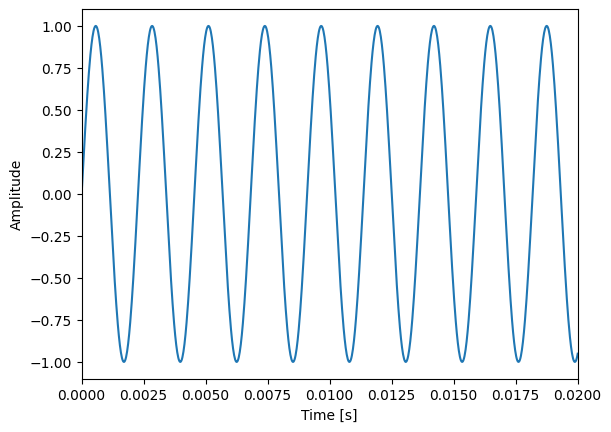

In [23]:
# plotting part of the stimulus
plt.figure(1)
plt.plot(t_GT, y_GT)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim((0, 0.02))

# plt.figure(2)
# plt.plot(t,HWin)
# plt.plot(t_Con, y_Con)
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.xlim((0, 0.02))
# plt.show()

#sd.play(x, fs)
sd.play(y_GT, fs_GT)
# sd.play(y_Con, fs_Con)

In [6]:
#concatenate the stimulus with some silence afterwards to see model ringdown
#output = x
#plt.figure(3)
#plt.plot(t,x)

In [2]:
x = adjust_spl(x, L)
# parameters for gammatone analysis
fmin = 50. #lowest frequency simulated for GT
numbands = 64 #number of GT bands
fs_nn = 20e3 # CoNNear requires 20kHz

# Parameters for the cochleagram figures
framelength_t = 0.025/4 # framelength in time 
frameshift_t = 0.01/4 # frameshift in time 
#for the GT
framelength_gt = int(framelength_t * fs)
frameshift_gt = int(frameshift_t * fs)

#for the CoNNear model
framelength_nn = int(framelength_t * fs_nn)
frameshift_nn = int(frameshift_t * fs_nn)

# Calculate the gammatone model and cochleagrams
gt_out = gammatone_analysis(x, fs, numbands, fmin)
gt_cochleagram = cochleagram(gt_out['bmm'], framelength_gt, frameshift_gt)
t_gt = np.arange(len(x)) / fs

# Calculate the CoNNear model and cochleagrams
print("Resampling signal to " + str(fs_nn) + " Hz")
x_nn = sp_sig.resample_poly(x, fs_nn, fs)
x_nn = np.expand_dims(x_nn, axis=0)
x_nn = np.expand_dims(x_nn, axis=2)
nn_out = connear.predict(x_nn)
nn_out = nn_out[0,:,:]
nn_cochleagram = cochleagram(nn_out.T, int(framelength_t * fs_nn), int(frameshift_t * fs_nn))
t_nn = np.arange(len(x_nn)) / fs_nn


NameError: name 'x' is not defined

In [8]:
#The indexes belonging to the 1 kHz frequency channels
#You can modify some parts of this code to see the response to a different CF channel 
Nch,N = np.shape(gt_out['bmm'])
Nch_nn,N_nn= np.shape(nn_out)
Bch_gt = np.nonzero(gt_out['cf']<1000) #get the CF channels with values < 1000 Hz
Bch_gt
Ch1k_gt = int(42)
Ch1k_nn = int(78) # CF channels with values < 1000 Hz for CoNNear

gt = np.zeros((Nch, N)) #copy the data so we can work with it
gt = gt_out['bmm'];

nn = np.zeros((Nch_nn, N_nn)) #copy the data so we can work with it
nn = nn_out.T;

#get the 1kHz-CF time-domain signal vs energy signal in specific bins
gt_1k = gt[Ch1k_gt,:] #time domain signal gt
nn_1k = nn[Ch1k_nn,:] #gt energy in 1-kHz channel, when used as preprocessing for Machine Hearing

plt.figure()
plt.plot(t_gt,gt_1k/max(gt_1k))
plt.plot(t_nn,nn_1k/max(nn_1k),'--')
plt.legend(['GT','CoNNear'])
#plt.xlim((0.1, 0.12))
plt.show()

NameError: name 'gt_out' is not defined

In [ ]:
#Generate a cochlear excitation pattern
#your code goes here

In [2]:
#Generate a click stimulus C_gt and C_nn: your code goes here
#outputs C_gt and C_nn as well as the time vectors: t_nn and t_gt
#plt.figure()
#plt.plot(t_gt,C_gt)
#plt.plot(t_nn,C_nn)

In [ ]:
#run the stimulus for different levels through the model
L_list=np.arange(10, 100, 10)
Cs_gt=np.zeros((Nch, N_gt, len(L_list)))
Cs_nn=np.zeros((Nch_nn, len(C_nn), len(L_list)))
Ps =np.zeros((N_gt, len(L_list)))

nCh_1k = 42 #to write out the 1-kHz channel, and example is only made for the GT model here
#you should add corresponding code for the CoNNear model
for nL,L in enumerate(L_list):
    x = adjust_spl(C_gt, L)
    result = gammatone_analysis(x, fs, numbands, fmin)
    Cs_gt[:, :, nL] = result['bmm']
    Ps[:, nL] = (2*abs(np.fft.fft(result['bmm'][nCh_1k, :]))/result['bmm'].shape[1])**2

plt.figure()
plt.plot(t_gt, Cs_gt[nCh_1k, :, :])

# Frequency domain
plt.figure()
freq_vect = np.fft.fftfreq(N_gt, d=1/fs)
plt.plot(freq_vect[:int(N_gt/2)], 10*np.log10(Ps[:int(N_gt/2)]))
plt.xlim((0, 8000))